In [1]:
#Standard libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import glob
import time

#Custom helper libraries.
import random
from utils import get_data, custom_flow, CNN, get_image, test_data

#GPU expanssion.
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from tensorflow.python.keras.backend import set_image_data_format

#Testing libraries
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#Augmentation
from augment import aug

#Random seed
seed = 1234

#Visuals
set_image_data_format('channels_last')

### Initial Parameters

In [2]:
#General params.
mask = False
name = 'rand'

#Network params.
train_size = 1050
test_size = 300
nb_epochs = 500
batch_size = 75
nb_steps_per_epoch = int(train_size/batch_size)
nb_validation_steps = int(test_size/batch_size)

#Cross-validation folds.
k = 5

#Ensambles.
nb_ensambles = 5

#Predictions.
nb_preds = 5

### Training and Cross-Validation

In [3]:
if mask == True:
    maskSTR = '_mask'
else:
    maskSTR = ''

allDATA = ['stacked',
           'threshold' + maskSTR +'_3sig', 'threshold' + maskSTR + '_5sig',
           'threshold' + maskSTR + '_3sig', 'threshold' + maskSTR + '_5sig']

kFold_data = []
kFold_labels = []
kFold_testing = []

#Get 5 folds of data for each dataset.
for i in range (len(allDATA)):
    
    data, data1, data0 = get_data(allDATA[i])

    #Split data into folds.
    foldsALL = []
    labelsALL_1 = []
    labelsALL_0 = []
    labelsALL = []

    for n in range(k):
        fold = np.concatenate((data1[int(n*len(data1)/k):int((n+1)*len(data1)/k)],
                               data0[int(n*len(data0)/k):int((n+1)*len(data0)/k)]), axis = 0)

        label1 = [1 for i in range (int(n*len(data1)/k),int((n+1)*len(data1)/k))]
        label0 = [0 for i in range (int(n*len(data0)/k),int((n+1)*len(data0)/k))]

        foldsALL.append(fold)
        labelsALL_1.append(len(label1))
        labelsALL_0.append(label0)
        labelsALL.append((label1, label0))
        
    #Data and labels in data order. (ie. kFold[0] = 5 folds of 'stacked' data)
    kFold_data.append(foldsALL)
    kFold_labels.append(labelsALL_1)
    
    #For comparing across augmentations.
    if i == 3 or i == 4:
        SCALE = True
        mask = mask
    elif i == 1 or i == 2:
        SCALE = False
        mask = mask
    else:
        SCALE = False
        mask = False

In [4]:
#Initial report.
print('Ensemble Configuration B\n{}-fold cross validation on {} epochs.\nTrain size: {}\nValidation size: {}\n'
      .format(k, nb_epochs, train_size, test_size))
print('------------------------------------')

#Store metrics and predictions.
mean_loss = []
mean_val_loss = []
mean_acc = []
mean_val_acc = []
pred_mean_folds = []
label_mean_folds = []

startALL = time.time()

for i in range (k):
    startFold = time.time()
    
    foldPrediction = []

    epochs = []
    loss = []
    val_loss = []
    acc = []
    val_acc = []
    
    for j in range (len(allDATA)):
        start = time.time()
        
        #Specify validation data.
        test1 = kFold_data[j][i][:kFold_labels[j][i]]
        test0 = kFold_data[j][i][kFold_labels[j][i]:]
        
        #Remove validation fold.
        fold_num = [0,1,2,3,4]
        fold_num.remove(i)
        
        train1 = []
        train0 = []
        
        for num in fold_num:
            train1.append(kFold_data[j][num][:kFold_labels[j][num]])
            train0.append(kFold_data[j][num][kFold_labels[j][num]:])
            
        
        trainData_0 = np.concatenate((train0[0], train0[1], train0[2], train0[3]), axis = 0)
        trainData_1 = np.concatenate((train1[0], train1[1], train1[2], train1[3]), axis = 0)
        
        #Log scale and pixel mask.
        if j == 3 or j == 4:
            SCALE = True
            mask = mask
        elif j == 1 or j == 2:
            SCALE = False
            mask = mask
        else:
            SCALE = False
            mask = False
            
        #Specify data generators.
        train_gen = custom_flow(trainData_0,
                                trainData_1,
                                batch_size,
                                augment = True, SCALE = SCALE, mask = mask)

        test_gen = custom_flow(test0,
                               test1,
                               batch_size,
                               augment = True, SCALE = SCALE, mask = mask)

        #Specify and train model.
        model = CNN()
        hist = model.fit(train_gen,
                         steps_per_epoch = nb_steps_per_epoch,
                         epochs = nb_epochs,
                         validation_data = test_gen,
                         validation_steps = nb_validation_steps,
                         verbose = 0)
        
        #Record metrics
        epochs.append(list(range(1, len(hist.history['loss']) + 1)))
        loss.append(hist.history['loss'])
        val_loss.append(hist.history['val_loss'])
        acc.append(hist.history['accuracy'])
        val_acc.append(hist.history['val_accuracy'])

        #Get augmentation averaged predictions.
        predictions = []
        
        for p in range (nb_preds):
            pred0 = [aug(get_image(image, SCALE, mask)) for image in test0]
            pred1 = [aug(get_image(image, SCALE, mask)) for image in test1] 
            predictions.append(model.predict(np.concatenate((pred0, pred1))))
            
        label0 = np.zeros(len(pred0))
        label1 = np.ones(len(pred1))
        
        #Save predictions and labels for network n.
        foldPrediction.append(np.mean(np.array(predictions), axis = 0))
        pred_labels = np.concatenate((label0, label1))
        
        #Progress report.
        finish = time.time()
        print('{} model completed. ({:.0f} minutes)'.format(allDATA[j], (finish - start)/60))
    
    #Mean metrics for fold.
    mean_loss.append(np.mean(loss, axis = 0))
    mean_val_loss.append(np.mean(val_loss, axis = 0))
    mean_acc.append(np.mean(acc, axis = 0))
    mean_val_acc.append(np.mean(val_acc, axis = 0))
    
    #Predictions accross data sets for single fold.
    pred_matrix = np.concatenate((foldPrediction[0], foldPrediction[1],
                                  foldPrediction[2], foldPrediction[3],
                                  foldPrediction[4]), axis = 1)
    
    #Get MEAN predictions for fold.
    pred_mean_folds.append(np.mean(pred_matrix, axis = 1))
    label_mean_folds.append(pred_labels)
    
    #Report fold completion.
    finishFold = time.time()
    print('Fold {}/{} Completed!'.format(i+1, k))
    print('Completion time: {:.0f} minutes. \n'.format((finishFold - startFold)/60))
    if i == k-1:
        print('Total {}-fold CV completion time: {:.0f} minutes ({:.1f} hours).'
              .format(k, (finish - startALL)/60,(finishFold - startALL)/3600))
        
#Get metrics for all folds.
loss_CV = np.mean(np.array(mean_loss), axis = 0)
val_loss_CV = np.mean(np.array(mean_val_loss), axis = 0)
acc_CV = np.mean(np.array(mean_acc), axis = 0)
val_acc_CV = np.mean(np.array(mean_val_acc), axis = 0)

#Get predictions for all folds.
predB_CV = np.concatenate((pred_mean_folds[0], pred_mean_folds[1], pred_mean_folds[2], 
                          pred_mean_folds[3], pred_mean_folds[4]))

labelB_CV = np.concatenate((label_mean_folds[0], label_mean_folds[1], label_mean_folds[2],
                           label_mean_folds[3], label_mean_folds[4]))
#Save predictions to file.
np.savetxt('predictions_full/ensembleB_CV_predictions_'+ str(nb_epochs) +'.csv', predB_CV, delimiter = ',')
np.savetxt('predictions_full/ensembleB_CV_labels.csv', labelB_CV, delimiter = ',')
print('Predictions saved!')


Ensemble Configuration B
5-fold cross validation on 500 epochs.
Train size: 1050
Validation size: 300

------------------------------------
stacked model completed. (39 minutes)
threshold_3sig model completed. (38 minutes)
threshold_5sig model completed. (38 minutes)
threshold_3sig model completed. (44 minutes)
threshold_5sig model completed. (44 minutes)
Fold 1/5 Completed!
Completion time: 204 minutes. 

stacked model completed. (39 minutes)
threshold_3sig model completed. (38 minutes)
threshold_5sig model completed. (38 minutes)
threshold_3sig model completed. (44 minutes)
threshold_5sig model completed. (44 minutes)
Fold 2/5 Completed!
Completion time: 204 minutes. 

stacked model completed. (39 minutes)
threshold_3sig model completed. (38 minutes)
threshold_5sig model completed. (38 minutes)
threshold_3sig model completed. (44 minutes)
threshold_5sig model completed. (44 minutes)
Fold 3/5 Completed!
Completion time: 204 minutes. 

stacked model completed. (39 minutes)
threshold_3s

### Performance Evaluation

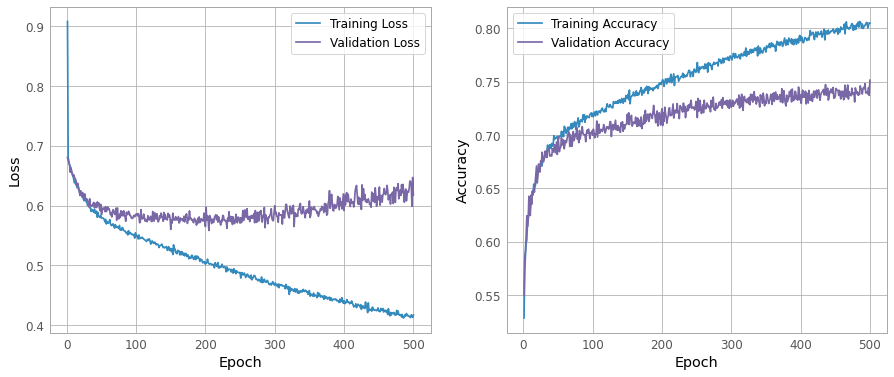

In [5]:
#Plot metrics
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

ax[0].plot(np.mean(np.array(epochs), axis = 0), loss_CV, label = 'Training Loss')
ax[0].plot(np.mean(np.array(epochs), axis = 0), val_loss_CV, label = 'Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(np.mean(np.array(epochs), axis = 0), acc_CV, label = 'Training Accuracy')
ax[1].plot(np.mean(np.array(epochs), axis = 0), val_acc_CV, label = 'Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

#Save plot.
plt.savefig('plots/ensembleB_CV_' + str(nb_epochs) + '.png')
plt.show();

### Final model training